# Facilities KPI Scorecard
This notebook serves as a repository of public-facing KPIs for the Department of General Services' Facilities Division. The purpose of this notebook is to have, in a single public place, the entire pipeline for calculating the division's three KPIs that are based in Archibus. Those KPIs are:

1. % of Corrective Maintenance Work Requests Completed On Time
2. % of Preventive Maintenance Work Requests Completed On Time
3. Preventive Maintenace to Corrective Maintenance Ratio

Part of the intention of this notebook is to build _transparency_ and _reproducibility_ by capturing the entire end-to-end process used to calculate these metrics in one place.

## Setup

### Import packages

In [1]:
# workhorse modules
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import re
from pathlib import Path
import seaborn as sns
import datadotworld as dw
import matplotlib.pyplot as plt

# local utility functions
from utils import (
    add_cm_benchmarks,
    add_fiscal_year,
    set_pd_params,
    tidy_up_df,
    cast_dtypes,
    glue_date_time,
    compute_days_to_completion,
    consolidate_prob_types,
    compute_pm_cm,
    compute_pm_cm_by_month,
    compute_kpi_table,
)

from vis_utils import set_plot_params, pointplot_with_barplot

### Set pandas options
This makes Pandas print all rows and columns to the output when requested.

In [2]:
set_pd_params()
set_plot_params()
pd.options.mode.chained_assignment = None  # default='warn'

### Import the work order data from Data.World
This data is a copy of Archibus's `wrhwr` table stored at DGS's account on Data.World. To see the exact query used to generate the input data, see `/sql/input_for_FMD_KPIs.sql`.

In [3]:
kpis_raw = dw.query(
    dataset_key="dgsbpio/auditfinding3", query="select * from wrhwr_02042021"
).dataframe

In [4]:
print(f"The work orders dataframe has {kpis_raw.shape[0]:,} rows.")

kpis_raw.sample(3, random_state=444)[["wr_id", "prob_type", "date_requested"]]

The work orders dataframe has 105,994 rows.


,wr_id,prob_type,date_requested
43021,67692,LAWN,2016-06-15
38037,62755,ELEC/LIGHT,2016-03-03
86771,117819,PLUMB/LEAK,2019-02-27


### Import the users table
The only reason why we need this second table is to figure out which work requests of type "OTHER" were requested by FMD staff and which were requested by a Service Request Liaison. 

OTHERs requested internally will be given the primary problem type "OTHER-INTERNAL", while OTHERs requested by SRLs will be given the primary problem type "OTHER-EXTERNAL".

In [5]:
users = dw.query(
    dataset_key="dgsbpio/auditfinding3", query="select * from archibus_user_roles"
).dataframe

users = users.applymap(lambda x: x.strip() if isinstance(x, str) else x)

## Data cleaning
For the purposes of this project, DGS is keeping the cleaning stage very simple. We're not attempting to remove duplicates or outliers, both of which involve relatively complex operations. 

### Basic cleaning
- removes white spaces in strings to facilitate matching, 
- drops rows with no problem type, or rows created by a test,
- renames a few columns

In [6]:
# make sure each column is of the correct data type
wr_tidy = cast_dtypes(kpis_raw)
# basic cleaning
wr_tidy = tidy_up_df(wr_tidy)

print(f"The tidied work orders dataframe has {len(wr_tidy):,} rows.")
print(f"By tidying the data, we have removed {len(kpis_raw) - len(wr_tidy):,} rows.")

The tidied work orders dataframe has 105,867 rows.
By tidying the data, we have removed 127 rows.


### Drop canceled work orders
The data comes to us with many canceled work orders. Those shouldn't count against us as not having been completed on time. So we drop them here. 

In [7]:
# drop rows that were canceled
cond_valid = wr_tidy["status"] != "Can"

wr_valid = wr_tidy[cond_valid]

print(
    f"By dropping canceled work orders, we have removed {len(wr_tidy) - len(wr_valid):,} rows."
)

By dropping canceled work orders, we have removed 3,328 rows.


### Combine date and time columns to get timestamps
This takes the date from a date column and the time from a time column and combines them into a single timestamp.

This transformation allows us to know the time to completion with greater precision. 

In [8]:
# glue the date and time for request
wr_dt = glue_date_time(wr_valid, "date_requested", "time_requested", "requested_dt")

# glue the date and time for completion
wr_dt = glue_date_time(wr_dt, "date_completed", "time_completed", "completed_dt")

# convert "date closed" to a valid datetime (this column has no time information)
wr_dt["date_closed"] = wr_dt["date_closed"].astype("datetime64")

### Examine the cleaned data
The display below gives us a sense of what some key columns in the data now look like. 

In [9]:
wr_dt[
    [
        "wr_id",
        "problem_type",
        "requested_dt",
        "completed_dt",
        "date_closed",
        "status",
    ]
].sample(3, random_state=451)

,wr_id,problem_type,requested_dt,completed_dt,date_closed,status
87362,118433,ELECTRICAL,2019-03-14 15:17:14,2019-03-29 12:02:12,2019-04-10 12:16:29.303,Clo
49206,76409,PLUMB/OTHER,2016-10-18 07:17:23,2016-10-26 08:44:34,2017-01-11 10:14:13.230,Clo
90634,123723,LOCK,2019-07-22 11:45:08,2019-10-30 09:55:31,2020-01-27 10:42:19.447,Clo


## Data preparation

### Merge work requests and user data
Now we bring the data from the users table into the work request table. This lets us figure out the rose of the user who requested each work request. 

In [10]:
wr_joined = wr_dt.merge(
    users[["user_name", "role_name"]],
    how="left",
    left_on="requestor",
    right_on="user_name",
)

### Add days to completion
Next, we compute the duration of time between the request and completion, for each job. We store that number in a column called "days_to_completion". 

In [11]:
wr_durations = compute_days_to_completion(wr_joined)

Let's check out three rows of the data, now that we've added some columns. Notice that `days_to_completion` is empty if the work request hasn't been marked completed yet. 

In [12]:
wr_durations[
    [
        "wr_id",
        "role_name",
        "problem_type",
        "requested_dt",
        "completed_dt",
        "date_closed",
        "days_to_completion",
        "status",
    ]
].sample(3, random_state=446)

,wr_id,role_name,problem_type,requested_dt,completed_dt,date_closed,days_to_completion,status
requested_dt,,,,,,,,
2014-02-06 13:41:41,5516,CRAFTSPERSON - BOC,_DELIVERY,2014-02-06 13:41:41,2014-02-07 07:42:59,2014-02-07 00:00:00.000,0.75,Clo
2018-10-15 14:24:27,112088,GATEKEEPER-RESTRICTED - BOC,HVAC,2018-10-15 14:24:27,2018-11-14 14:48:12,2019-01-29 10:21:36.630,30.02,Clo
2018-11-08 15:54:55,112983,GATEKEEPER - BOC,PLUMBING-SANITARY,2018-11-08 15:54:55,2019-01-02 11:58:59,2019-01-03 13:05:22.103,54.84,Clo


### Add fiscal year
There are different ways to assign a fiscal year to a work request. Currently, we're doing it by the fiscal year in which the work request was closed. Other options would include the fiscal year of the request. 


In [13]:
wr_fy = add_fiscal_year(wr_durations, assign_fy_on="closure")

After assigning the fiscal year, we can drop work requests from FY15 and older. 

In [14]:
cond_fy = wr_fy["fiscal_year"].isin(range(2016, 2022))
wr_fy = wr_fy[cond_fy]

## KPI: % PMs Completed On Time 
The goal here is to filter the data down to preventive maintenance only, and then show how many are completed on or before the benchmark (21 days).

### Filter to valid PM only, and for relevant fiscal years only
After noticing that many PMs have the status "Can" — meaning they were canceled — we fil

In [15]:
# this defines which problem types are considered PMs
pm_list = [
    "BUILDING INTERIOR INSPECTION",
    "BUILDING PM",
    "HVAC|PM",
    "INSEPCTION",
    "PREVENTIVE MAINT",
]

# filter data to PM types only
cond_pm = wr_fy["problem_type"].isin(pm_list)

# apply filter conditions
wr_pm = wr_fy[cond_pm]

print(f"The filtered PMs dataframe has {wr_pm.shape[0]:,} rows.")

The filtered PMs dataframe has 6,717 rows.


#### Compute the benchmark and add `is_on_time` column
Here we tell Python that PMs are on-time if completed in 21 days. 

Then the function `compute_is_on_time` compares the column `days_to_completion` to the benchmark and writes down whether the work request was completed on time. 

In [16]:
def compute_is_on_time(row):
    row["is_on_time"] = row["days_to_completion"] <= row["benchmark"]
    return row


# assign benchmark
wr_pm["benchmark"] = 21

# add "is_on_time" column with performance data
pms_on_time = wr_pm.apply(compute_is_on_time, axis=1)

In [17]:
pms_on_time[
    [
        "wr_id",
        "problem_type",
        "requested_dt",
        "completed_dt",
        "days_to_completion",
        "is_on_time",
        "status",
    ]
].sample(3, random_state=446)

,wr_id,problem_type,requested_dt,completed_dt,days_to_completion,is_on_time,status
requested_dt,,,,,,,
2016-09-01 22:03:03,74111,PREVENTIVE MAINT,2016-09-01 22:03:03,2016-10-20 09:16:19,48.47,False,Clo
2017-06-01 13:14:21,88762,BUILDING PM,2017-06-01 13:14:21,2017-06-01 13:14:24,0.00,True,Clo
2019-01-26 06:00:47,115642,PREVENTIVE MAINT,2019-01-26 06:00:47,2019-01-28 08:08:14,2.09,True,Clo


#### Group by fiscal year and get % on time
Now that we've stored all this information, we can group by the fiscal year to get each year's KPI, together with a count of how many PMs 

In [18]:
pm_compliance = compute_kpi_table(pms_on_time, "percent_PMs_on_time", "total_PMs")
pm_compliance

,percent_PMs_on_time,total_PMs
fiscal_year,,
2016,73.28,741
2017,50.63,1341
2018,79.24,1137
2019,92.15,764
2020,48.67,1952
2021,32.35,782


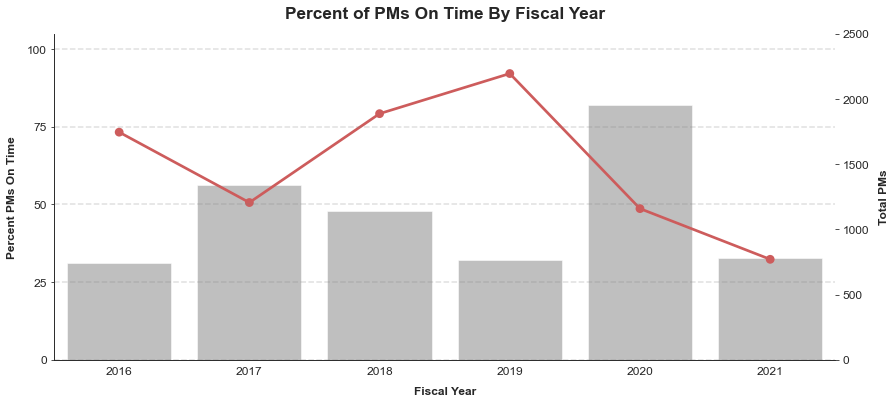

In [19]:
pointplot_with_barplot(
    pm_compliance,
    x="fiscal_year",
    point_y="percent_PMs_on_time",
    bar_y="total_PMs",
    ymax_bar=2_500,
    ylabel_point="Percent PMs On Time",
    ylabel_bar="Total PMs",
    title="Percent of PMs On Time By Fiscal Year",
)

## KPI: PM:CM Ratio

The two lists below contain the exact same problem types mentioned in last year's scorecard. So we would expect to be able to replicate last year's results closely.

In [20]:
CM_list = [
    "BOILER",
    "CHILLERS",
    "COOLING TOWERS",
    "HVAC",
    "HVAC INFRASTRUCTURE",
    "HVAC|REPAIR",
]

PM_list = [
    "HVAC|PM",
    "PREVENTIVE MAINT",
]

### Filter to HVAC rows only

In [21]:
cond_cm = wr_fy["problem_type"].isin(CM_list)
cond_pm = wr_fy["problem_type"].isin(PM_list)

wr_HVAC = wr_fy[cond_cm | cond_pm]
wr_HVAC["is_pm"] = wr_HVAC["problem_type"].isin(PM_list)

print(
    f"Filtering to HVAC request only takes us from {len(wr_fy):,} rows to {len(wr_HVAC):,} rows."
)

Filtering to HVAC request only takes us from 65,211 rows to 16,630 rows.


### Compute all PM/CM stats by fiscal year
First we deploy a custom function that counts the PMs and CMs in each fiscal year and then calculates the PM:CM ratio.

In [22]:
pm_cm_results = compute_pm_cm(wr_HVAC, PM_list)

In [23]:
pm_cm_results

,fiscal_year,pm_cm_ratio,count_cm,count_pm,count_hvac
0,2016,49.07,1400,687,2087
1,2017,47.25,2671,1262,3933
2,2018,61.39,1764,1083,2847
3,2019,31.83,1304,415,1719
4,2020,71.76,2507,1799,4306
5,2021,80.10,965,773,1738


### Plot PM:CM ratio by fiscal year

/Users/james/Documents/Bmore/repos/KPI_central/vis_utils.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(yticklabels)


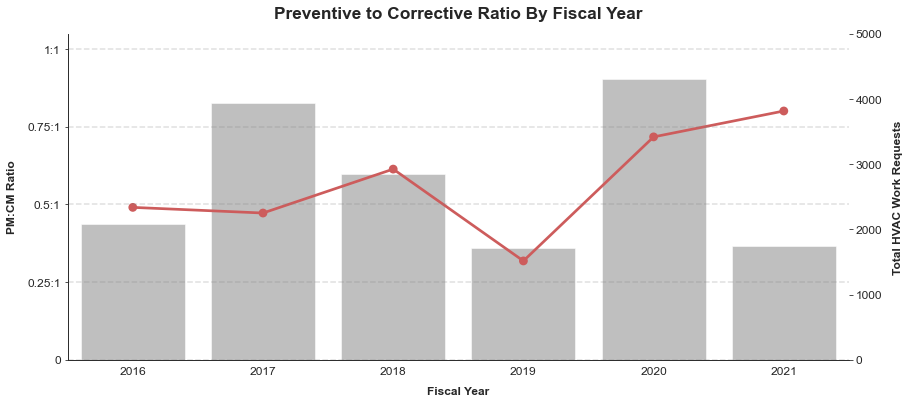

In [24]:
pointplot_with_barplot(
    pm_cm_results,
    x="fiscal_year",
    point_y="pm_cm_ratio",
    bar_y="count_hvac",
    ymax_bar=5_000,
    ylabel_point="PM:CM Ratio",
    ylabel_bar="Total HVAC Work Requests",
    title="Preventive to Corrective Ratio By Fiscal Year",
    yticklabels=["0", "0", "0.25:1", "0.5:1", "0.75:1", "1:1"],
)

### Plot the number of PMs and CMs by fiscal year
We can get a little more insight into what's going on with the ratio by checking out the raw counts of preventive and corrective maintenance work requests by fiscal year. 

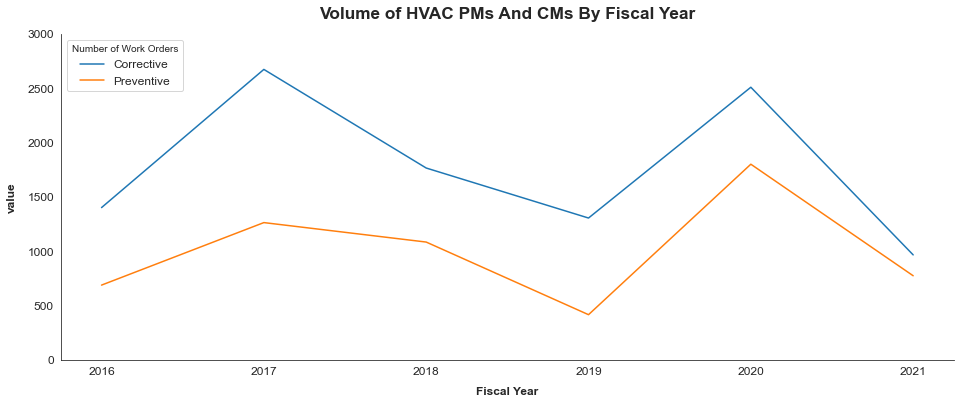

In [25]:
count_plot_data = pd.melt(
    pm_cm_results, id_vars=["fiscal_year"], value_vars=["count_cm", "count_pm"]
)

ax = sns.lineplot(data=count_plot_data, y="value", x="fiscal_year", hue="variable")
new_labels = ["Corrective", "Preventive"]
plt.legend(title="Number of Work Orders", loc="upper left", labels=new_labels)

ax.set(
    title="Volume of HVAC PMs And CMs By Fiscal Year",
    xlabel="Fiscal Year",
    ylim=(0, 3000),
)
sns.despine()

## KPI: Percent of CM Work Requests Completed On-Time
Here are the key facts needed to understand the agency's new method for computing this KPI:

- Only CM problem types are considered, so all PM work orders are dropped.
- The work orders are first assigned a "primary" problem type, which consolidates the number of problem types
- Each of these primary problem types has a benchmark, which is then added to the work request's row
- Finally, the work order is determined to be on-time based on comparing its time to completion to its benchmark

### Consolidate many problem types into primary types
As shown below, consolidating all the different problem types gets us from a starting place of 110 problem types to only 30. Much more manageable to have 30 benchmarks than 110.

In [26]:
wr_cm = wr_fy.copy()

consolidated_wrs = wr_cm.apply(consolidate_prob_types, axis=1)

cond_cm = consolidated_wrs["primary"] != "PREVENTIVE"
consolidated_cms = consolidated_wrs[cond_cm]

print(
    f"Dropping some unbenchmarked small categories takes us from {len(consolidated_wrs):,} rows to {len(consolidated_cms):,} rows."
)

Dropping some unbenchmarked small categories takes us from 65,211 rows to 58,396 rows.


In [27]:
print(
    f"Consolidation takes us from {consolidated_wrs['problem_type'].nunique()} problem types to only {consolidated_wrs['primary'].nunique():,}."
)

Consolidation takes us from 110 problem types to only 30.


### Apply benchmarks
Now we look up the benchmark for each work request and add it in a new column. The function `add_cm_benchmarks()` contains the list of benchmarks and problem types.

In [28]:
cms_benchmarked = consolidated_cms.apply(add_cm_benchmarks, axis=1)

cms_benchmarked.sample(6, random_state=444)[
    ["problem_type", "primary", "benchmark", "days_to_completion"]
]

,problem_type,primary,benchmark,days_to_completion
requested_dt,,,,
2016-06-20 10:03:20,HVAC,HVAC,30.0,51.01
2019-10-15 11:04:28,HVAC,HVAC,30.0,91.09
2018-10-23 15:21:02,SERV/CUSTODIAL,SERVICE,14.0,119.66
2015-06-05 09:58:49,PLUMB/OTHER,PLUMBING,14.0,0.00
2019-03-07 08:45:49,BATHROOM_FIXT,BATHROOM,14.0,419.10
2016-04-14 10:05:14,ENVIR/ASBESTOS,ENVIRONMENTAL,45.0,130.97


### Compute whether requests are on time

In [29]:
cms_on_time = cms_benchmarked.apply(compute_is_on_time, axis=1)

### Group by fiscal year to get KPI

In [30]:
cm_compliance = compute_kpi_table(cms_on_time, "percent_CMs_on_time", "total_CMs")
cm_compliance

,percent_CMs_on_time,total_CMs
fiscal_year,,
2016,78.04,13384
2017,70.55,13979
2018,70.62,10021
2019,65.82,5693
2020,53.24,9076
2021,30.79,6243


### Plot % CMs on time by fiscal year

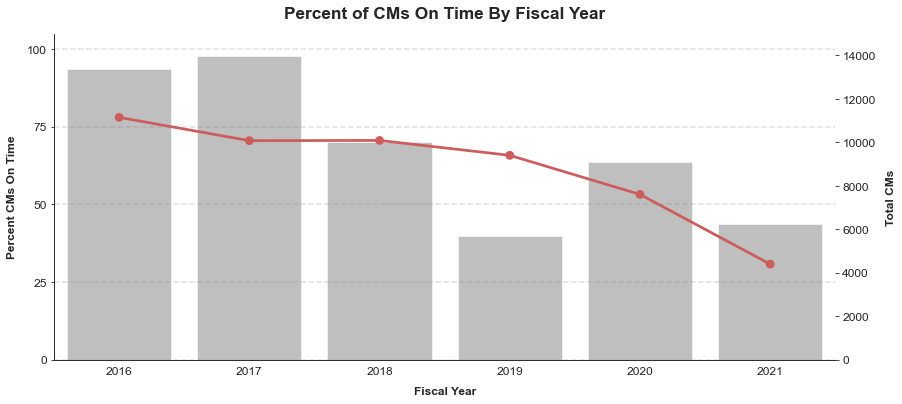

In [31]:
pointplot_with_barplot(
    cm_compliance,
    x="fiscal_year",
    point_y="percent_CMs_on_time",
    bar_y="total_CMs",
    ymax_bar=15_000,
    ylabel_point="Percent CMs On Time",
    ylabel_bar="Total CMs",
    title="Percent of CMs On Time By Fiscal Year",
)

## Monthly figures for current FY

### PMs on Time

In [32]:
def compute_kpi_table_by_month(df, label_for_KPI=None, label_for_totals=None):
    df = df.copy()
    # filter to current fy
    cond_current_fy = df["fiscal_year"] == 2021
    df = df[cond_current_fy]
    table_df = (
        df[["wr_id", "date_closed", "is_on_time"]]
        .resample("M", on="date_closed")
        .agg({"is_on_time": "mean", "wr_id": "count"})
    )
    table_df["year_month"] = table_df.index.strftime("%b-%y")
    table_df["is_on_time"] = table_df["is_on_time"].apply(lambda x: round(x * 100, 2))
    table_df = table_df.rename(
        columns={"is_on_time": label_for_KPI, "wr_id": label_for_totals}
    )
    return table_df


pms_on_time_current_fy = compute_kpi_table_by_month(
    pms_on_time, "percent_PMs_on_time", "total_PMs"
)
pms_on_time_current_fy

,percent_PMs_on_time,total_PMs,year_month
date_closed,,,
2020-07-31,78.46,65,Jul-20
2020-08-31,46.15,13,Aug-20
2020-09-30,37.50,8,Sep-20
2020-10-31,NaN,0,Oct-20
2020-11-30,27.89,649,Nov-20
2020-12-31,9.09,22,Dec-20
2021-01-31,40.00,25,Jan-21


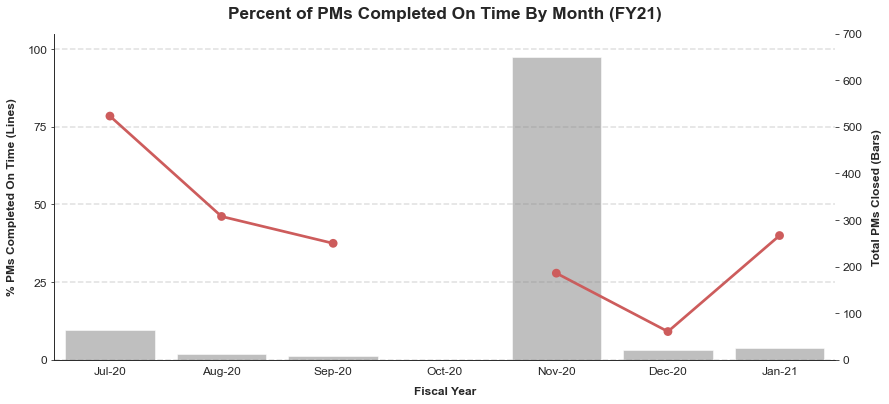

In [33]:
pointplot_with_barplot(
    pms_on_time_current_fy,
    x="year_month",
    point_y="percent_PMs_on_time",
    bar_y="total_PMs",
    ymax_bar=700,
    ylabel_point="% PMs Completed On Time (Lines)",
    ylabel_bar="Total PMs Closed (Bars)",
    title="Percent of PMs Completed On Time By Month (FY21)",
)

### PM:CM Ratio

In [34]:
pm_cm_ratio_current_fy = compute_pm_cm_by_month(wr_HVAC, PM_list)
pm_cm_ratio_current_fy

,year_month,pm_cm_ratio,count_cm,count_pm,count_hvac
0,Jul-20,900.00,7,63,70
1,Aug-20,28.89,45,13,58
2,Sep-20,9.62,52,5,57
3,Oct-20,0.00,23,0,23
4,Nov-20,156.04,414,646,1060
5,Dec-20,7.39,284,21,305
6,Jan-21,33.33,75,25,100


/Users/james/Documents/Bmore/repos/KPI_central/vis_utils.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(yticklabels)


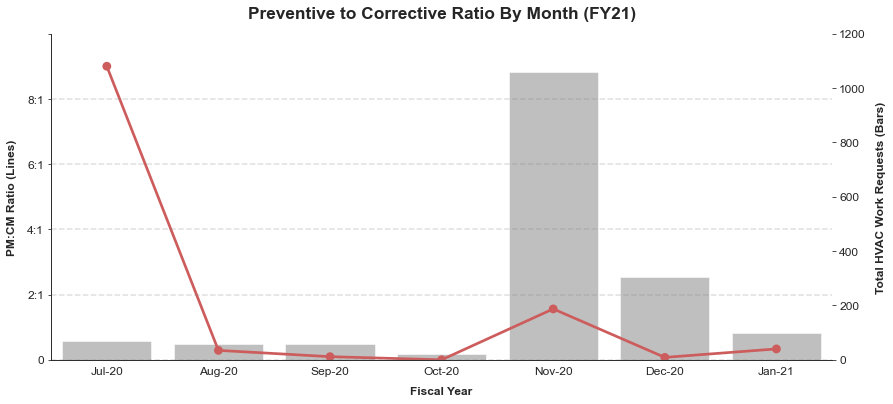

In [35]:
pointplot_with_barplot(
    pm_cm_ratio_current_fy,
    x="year_month",
    point_y="pm_cm_ratio",
    bar_y="count_hvac",
    yaxis_freq=200,
    ymax_point=1_000,
    ymax_bar=1_200,
    ylabel_point="PM:CM Ratio (Lines)",
    ylabel_bar="Total HVAC Work Requests (Bars)",
    title="Preventive to Corrective Ratio By Month (FY21)",
    yticklabels=[
        "0",
        "0",
        "2:1",
        "4:1",
        "6:1",
        "8:1",
    ],
)

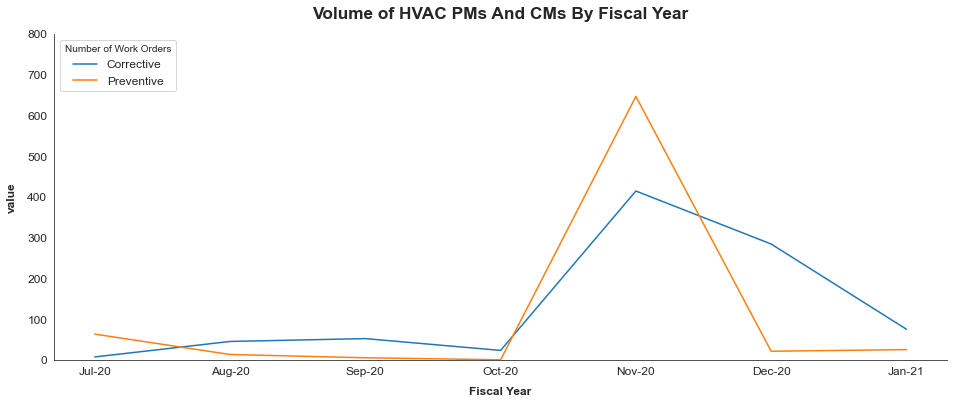

In [36]:
count_plot_data = pd.melt(
    pm_cm_ratio_current_fy, id_vars=["year_month"], value_vars=["count_cm", "count_pm"]
)

ax = sns.lineplot(data=count_plot_data, y="value", x="year_month", hue="variable")
new_labels = ["Corrective", "Preventive"]
plt.legend(title="Number of Work Orders", loc="upper left", labels=new_labels)

ax.set(
    title="Volume of HVAC PMs And CMs By Fiscal Year",
    xlabel="Fiscal Year",
    ylim=(0, 800),
)
sns.despine()